# <center>Supplementary Information for</center>
## <center>__Flexible Framework for Surface Hopping: From Hybrid Schemes for Machine Learning to Benchmarkable Nonadiabatic Dynamics__</center>
### <center>Jakub Martinka<sup>1,2</sup>,  Mikołaj Martyka<sup>3</sup>, Jiří Pittner<sup>1</sup> and Pavlo O. Dral<sup>*,4,5,6</sup>

$^1$ J. Heyrovský Institute of Physical Chemistry, Academy of Sciences of the Czech Republic, v.v.i., Dolejškova 3, 18223 Prague 8, Czech Republic<br>
$^2$ Department of Physical and Macromolecular Chemistry, Faculty of Sciences, Charles University, Hlavova 8, 128 43 Prague 2, Czech Republic<br>
$^3$ Faculty of Chemistry, University of Warsaw, Pasteura 1, Warsaw, 02-093, Poland
$^4$ State Key Laboratory of Physical Chemistry of Solid Surfaces, Department of Chemistry, College of Chemistry and Chemical Engineering, and Fujian Provincial Key Laboratory of Theoretical and Computational Chemistry, Xiamen University, Xiamen 361005, China<br>
$^5$ Institute of Physics, Faculty of Physics, Astronomy,and Informatics, Nicolaus Copernicus University in Toruń, ul. Grudziądzka 5, 87-100 Toruń, Poland<br>
$^6$ Aitomistic, Shenzhen, China<br>
$^*$ Corresponding authors: dral@xmu.edu.cn
___

Data used within this Jupyter Notebook are available from: https://github.com/JakubMartinka/FSSH-in-MLatom

Run `ansep.py` to create TRAJs or create `pop.txt`, run surface hopping by `run.py`, `data/` contains initial conditions and QC inputs and/or ML models.
Structure: 
- CNH4p
    - CNH4p_CASSCF_FSSH
    - CNH4p_CASSCF_LZSH
    - CNH4p_CASSCF_TDBA
    - CNH4p_MRCI_FSSH
- FERRO_WIRE
    - FERRO_WIRE_FSSH
    - FERRO_WIRE_LZSH
    - FERRO_WIRE_TDBA
    - FERRO_WIRE_TDBA_0.5eV
- FULVENE    
    - FULVENE_FSSH
    - FULVENE_FSSH_MLQM
    - FULVENE_FSSH_MLQM_0.5eV
    - FULVENE_LZSH
    - FULVENE_TDBA
    - FULVENE_TDBA_0.5eV
    - FULVENE_TDBA_dgrad - rescale velocity $g_{ij}$

Trajectories in H5MD format (exceeding 55 GB in total) can be provided upon request due to their size.
___

In [1]:
import mlatom as ml
import numpy as np
import os
root_dir = os.getcwd()

import matplotlib.pyplot as plt
# uncomment for latex-generated figures if cm-super and dvipng are installed
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', serif='Computer Modern')
plt.rc('font', size=16)

# Colors:
cg = '#0B3D0B'
cb1 = '#1E3A8A'
cb2 = '#3B82F6'
cp = '#800080'
co1 = '#9A3412'
co2 = '#F97316'
co3 = '#FDBA74'
colors = [cg, cb1, cb2, cp, co1, co2, co3]

cg1 = '#1b9e77'
co1 = '#d95f02'
cp1 = '#7570b3'
cr1 = '#e7298a'
cdg1 = '#014D4E'
cdr1 = '#8B0000'
colors1 = [cg1, co1, cp1, cr1, cdg1, cdr1]

In [2]:
# Function to save figures
from pathlib import Path
IMAGES_PATH = Path() / "res"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=1200):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, facecolor='white', transparent=False)

# Function for confidence interval
def mean_confidence_interval(p, N):
    return 1.96*np.sqrt(p * (1 - p) / N)

# Function to fit exponential function to get time scale
from scipy.optimize import curve_fit
def fit_exponential(time, pop):
    def f(t, A, tau):
        return A * (1 - np.exp(-t/tau))
    params, cov_matrix = curve_fit(f, time, pop, p0=[max(pop), 1.0])
    A_fit, tau_fit = params
    _, tau_err = np.sqrt(np.diag(cov_matrix))
    pop_fit = [f(i, A_fit, tau_fit) for i in time]
    return pop_fit, tau_fit, tau_err

# Function to extract hopping points
def get_hop_geos(traj):
    nstates = len(traj.steps[0].molecule.electronic_states)
    local_hop_list = [[[] for k in range(nstates)] for j in range(nstates)]
    for index, geom in enumerate(traj.steps):
        if index !=0:
            if geom.current_state != traj.steps[index-1].current_state:
                hop_to = int(geom.current_state)
                hop_from = int(traj.steps[index-1].current_state)
                traj.steps[index-1].molecule.hoptime = traj.steps[index-1].time
                local_hop_list[hop_from][hop_to].append(traj.steps[index-1].molecule)
    geoms = []
    for k in range(nstates):
        for j in range(nstates):
            if local_hop_list[k][j] != None:
                for hop_geom in local_hop_list[k][j]:
                    hop_geom.hop_from = k
                    hop_geom.hop_to = j
                    geoms.append(hop_geom)
    return geoms


___
## NAMD Keywords

FSSH:
```python
namd_kwargs = {
  'model': model,
  'time_step': 0.5,
  'time_step_tdse': 0.025,
  'maximum_propagation_time': 200,
  'hopping_algorithm': 'FSSH',
  'decoherence_model': 'SDM',
  'rescale_velocity_direction': 'nacs',
  'nstates': 4,
  'initial_state': 3
}
```

TDBA:
```python
namd_kwargs = {
  'model': model,
  'time_step': 0.5,
  'time_step_tdse': 0.025,
  'maximum_propagation_time': 200,
  'hopping_algorithm': 'TDBA',
  'decoherence_model': 'SDM',
  'rescale_velocity_direction': 'momentum',
  'nstates': 4,
  'initial_state': 3
}
```

LZSH:
```python
namd_kwargs = {
  'model': model,
  'time_step': 0.5,
  'maximum_propagation_time': 200,
  'hopping_algorithm': 'LZSH',
  'rescale_velocity_direction': 'momentum',
  'nstates': 4,
  'initial_state': 3
}
```
___

# 1. Fulvene
## Population data

In [3]:
pop_fulvene = {
    'FSSH': 200,            # CASSCF(6,6) FSSH
    'FSSH_MLQM': 200,       # MS-ANI + CASSCF(6,6) FSSH
    'FSSH_MLQM_0.5eV': 200, # MS-ANI + CASSCF(6,6) if dE<0.5eV FSSH
    'LZSH': 200,            # MS-ANI LZSH
    'TDBA': 200,            # MS-ANI TDBA
    'TDBA_0.5eV': 200,      # MS-ANI TDBA if dE<0.5eV
    'TDBA_dgrad': 200,      # MS-ANI TDBA rescale dgrad
    }

data_pop_fulvene = {'time': []}
for i, name in enumerate(pop_fulvene.keys()):
    data_pop_fulvene[name] = {'S0': [], 'S1': [], 'S0pe': [], 'S0me': [], 'S1pe': [], 'S1me': []}
    with open(f'examples/FULVENE_{name}/pop.txt', 'r') as ff:
        j = 0
        for line in ff.read().splitlines():
            values = list(map(float, line.split()))
            if i == 0:
                data_pop_fulvene['time'].append(values[0])
            data_pop_fulvene[name]['S0'].append(values[1])
            data_pop_fulvene[name]['S1'].append(values[2])
            err = mean_confidence_interval(data_pop_fulvene[name]['S0'][j], pop_fulvene[name])
            data_pop_fulvene[name]['S0pe'].append(data_pop_fulvene[name]['S0'][j]+err)
            data_pop_fulvene[name]['S0me'].append(data_pop_fulvene[name]['S0'][j]-err)
            err = mean_confidence_interval(data_pop_fulvene[name]['S1'][j], pop_fulvene[name])
            data_pop_fulvene[name]['S1pe'].append(data_pop_fulvene[name]['S1'][j]+err)
            data_pop_fulvene[name]['S1me'].append(data_pop_fulvene[name]['S1'][j]-err)
            j += 1

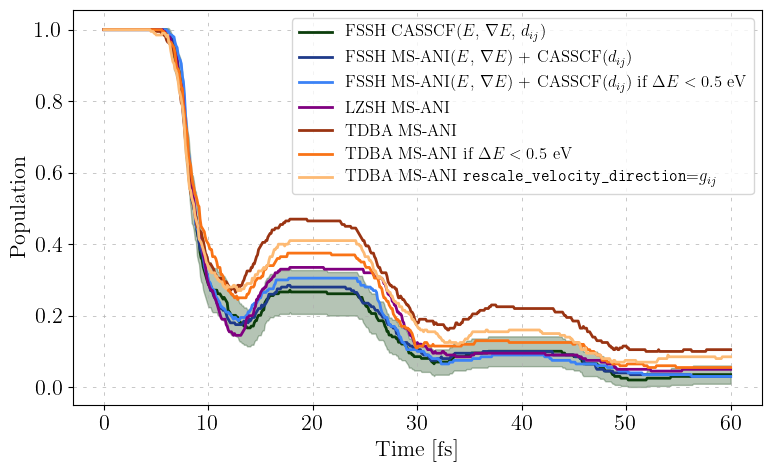

In [4]:
labels = [r'FSSH CASSCF($E$, $\nabla E$, $d_{ij}$)', r'FSSH MS-ANI($E$, $\nabla E$) + CASSCF($d_{ij}$)', r'FSSH MS-ANI($E$, $\nabla E$) + CASSCF($d_{ij}$) if $\Delta E<0.5$ eV', r'LZSH MS-ANI', r'TDBA MS-ANI', r'TDBA MS-ANI if $\Delta E<0.5$ eV', r'TDBA MS-ANI \texttt{rescale_velocity_direction}=$g_{ij}$']

fig, ax = plt.subplots(1, figsize=(8, 5))

for i, name in enumerate(pop_fulvene.keys()):
    ax.plot(data_pop_fulvene['time'], data_pop_fulvene[name]['S1'], c=colors[i], lw=2, label=labels[i])
    if name == 'FSSH': # show confidence interval for reference method
        ax.fill_between(data_pop_fulvene['time'], data_pop_fulvene[name]['S1pe'], data_pop_fulvene[name]['S1me'], color=colors[i], alpha=0.3)

ax.set_ylabel('Population')
ax.set_xlabel('Time [fs]')
ax.grid(linestyle = '--', dashes=(5, 9), linewidth = 0.5)

ax.legend(ncols=1, fontsize=12)

save_fig('populations_fulvene', tight_layout=True)
plt.tight_layout()
plt.show()


___
# 2. Ferro wire
## Population data

In [5]:
# wait for TRAJ31 LZSH
pop_ferrowire = {
    'FSSH': 266,
    'LZSH': 272,
    'TDBA': 270,
    #'TDBA_0.5eV': 272
    }
nstates = 4

data_pop_ferrowire = {key: {} for key in pop_ferrowire.keys()}
for i, name in enumerate(pop_ferrowire.keys()):
    data_pop_ferrowire[name] = {"time": [], **{f"S{i}{suffix}": [] for i in range(nstates) for suffix in ['', 'pe', 'me']}}
    with open(f'examples/FERRO_WIRE_{name}/pop.txt', 'r') as ff:
        for line in ff.read().splitlines():
            values = list(map(float, line.split()))
            data_pop_ferrowire[name]['time'].append(values[0])
            for i in range(nstates):
                data_pop_ferrowire[name][f'S{i}'].append(values[i+1])
                err = mean_confidence_interval(data_pop_ferrowire[name][f'S{i}'][-1], pop_ferrowire[name])
                data_pop_ferrowire[name][f'S{i}pe'].append(data_pop_ferrowire[name][f'S{i}'][-1]+err)
                data_pop_ferrowire[name][f'S{i}me'].append(data_pop_ferrowire[name][f'S{i}'][-1]-err)

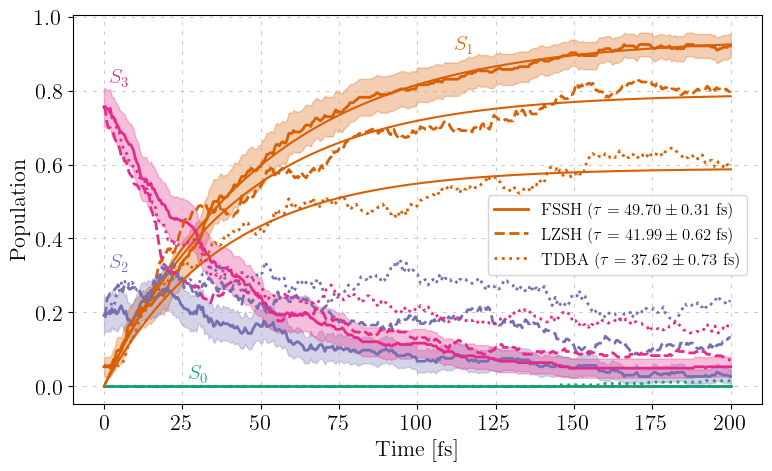

In [6]:
lines = ['-', '--', ':', '-.']

fig, ax = plt.subplots(1, figsize=(8, 5))

ax.text(27, 0.02, '$S_0$', c=colors1[0], fontsize=15)
ax.text(112, 0.91, '$S_1$', c=colors1[1], fontsize=15)
ax.text(2, 0.32, '$S_2$', c=colors1[2], fontsize=15)
ax.text(2, 0.82, '$S_3$', c=colors1[3], fontsize=15)

for i, name in enumerate(pop_ferrowire.keys()):
    for j in range(nstates):
        if j == 1:
            pop_fit, tau_fit, tau_err = fit_exponential(data_pop_ferrowire[name]['time'], data_pop_ferrowire[name]['S1'])
            ax.plot(data_pop_ferrowire[name]['time'], data_pop_ferrowire[name][f'S{j}'], lines[i], c=colors1[j], lw=2, label=name+rf" ($\tau = {tau_fit:.2f} \pm {tau_err:.2f}$ fs)")
            ax.plot(data_pop_ferrowire[name]['time'], pop_fit, c=colors1[j])
        else:
            ax.plot(data_pop_ferrowire[name]['time'], data_pop_ferrowire[name][f'S{j}'], lines[i], c=colors1[j], lw=2)
        if name == 'FSSH':
            ax.fill_between(data_pop_ferrowire[name]['time'], data_pop_ferrowire[name][f'S{j}pe'], data_pop_ferrowire[name][f'S{j}me'], color=colors1[j], alpha=0.3)

ax.set_ylabel('Population')
ax.set_xlabel('Time [fs]')
ax.grid(linestyle = '--', dashes=(5, 9), linewidth = 0.5)

ax.legend(loc="best", bbox_to_anchor=(0.59, 0.31), fontsize=12)

save_fig('populations_ferrowire', tight_layout=True)
plt.tight_layout()
plt.show()


## Erroneous hopping in TDBA trajectory

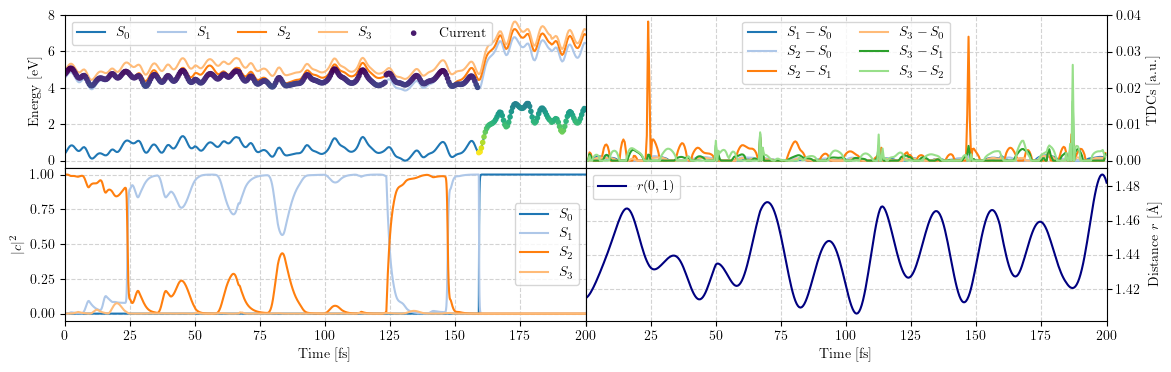

In [ ]:
#path = # path to examples/FERRO_WIRE_TDBA

traj = ml.data.molecular_trajectory()
traj.load(f'{path}/TRAJ200/traj1.h5', format='h5md')

ml.namd.plot_trajs([traj], dof=[[0,1]], time_step=0.5, time_substep=0.025, max_propagation_time=200, nstates=4, show_tdc=False, energy_distance=False, save_figure=False)

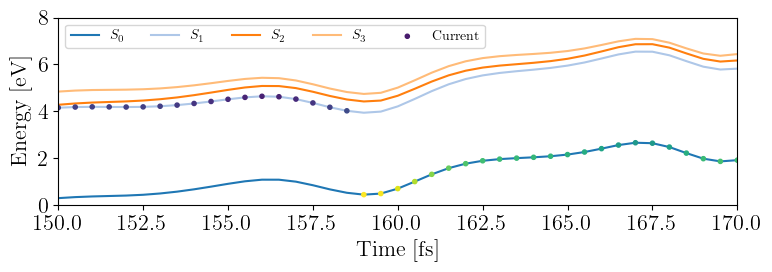

In [ ]:
#path = # path to examples/FERRO_WIRE_TDBA

traj = ml.data.molecular_trajectory()
traj.load(f'{path}/TRAJ200/traj1.h5', format='h5md')

fig, ax = plt.subplots(1, figsize=(8, 3))
ml.namd.plot_pes(ax, traj, time_step=0.5, max_propagation_time=200.0, nstates=4) # for PESs
#ml.namd.plot_tdc(ax, traj, time_step=0.5, max_propagation_time=200.0, nstates=4)  # for TDCs
#ml.namd.plot_pop(ax, traj, time_step=0.5, max_propagation_time=200.0, nstates=4) # for Population
#ml.namd.plot_dist(ax, traj, dof=[[0,1], [1,2]], time_step=0.5, max_propagation_time=200.0) # for DOF
ax.set_ylim([0,8])
ax.set_xlim([150,170])
ax.set_ylabel("Energy [eV]", fontsize=16)
ax.set_xlabel("Time [fs]")

save_fig('ferrowire_erroneous', tight_layout=True)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate energy difference for trajectory
#path = # path to examples/FERRO_WIRE_TDBA

traj = ml.data.molecular_trajectory()
traj.load(f'{path}/TRAJ200/traj1.h5', format='h5md')

for i in range(len(traj.steps)):
    current_state = int(traj.steps[i].current_state)
    if current_state == 0:
        previous_state = int(traj.steps[i-1].current_state)
        print(current_state, previous_state, abs(traj.steps[i].molecule.electronic_states[current_state].energy - traj.steps[i].molecule.electronic_states[previous_state].energy)*ml.constants.Hartree2eV)
        break

0 1 3.5002467199899443


# 3. Methylamonium cation
## Population data

In [9]:
pop_cnh4p = {
    'MRCI_FSSH': 63,
    'CASSCF_FSSH': 63,
    'CASSCF_LZSH': 63,
    'CASSCF_TDBA': 63,
    }

nstates = 3
data_pop_cnh4p = {key: {} for key in pop_cnh4p.keys()}
for i, name in enumerate(pop_cnh4p.keys()):
    data_pop_cnh4p[name] = {"time": [], **{f"S{i}{suffix}": [] for i in range(nstates) for suffix in ['', 'pe', 'me']}}
    with open(f'examples/CNH4p_{name}/pop.txt', 'r') as ff:
        for line in ff.read().splitlines():
            values = list(map(float, line.split()))
            data_pop_cnh4p[name]['time'].append(values[0])
            for i in range(nstates):
                data_pop_cnh4p[name][f'S{i}'].append(values[i+1])
                err = mean_confidence_interval(data_pop_cnh4p[name][f'S{i}'][-1], pop_cnh4p[name])
                data_pop_cnh4p[name][f'S{i}pe'].append(data_pop_cnh4p[name][f'S{i}'][-1]+err)
                data_pop_cnh4p[name][f'S{i}me'].append(data_pop_cnh4p[name][f'S{i}'][-1]-err)

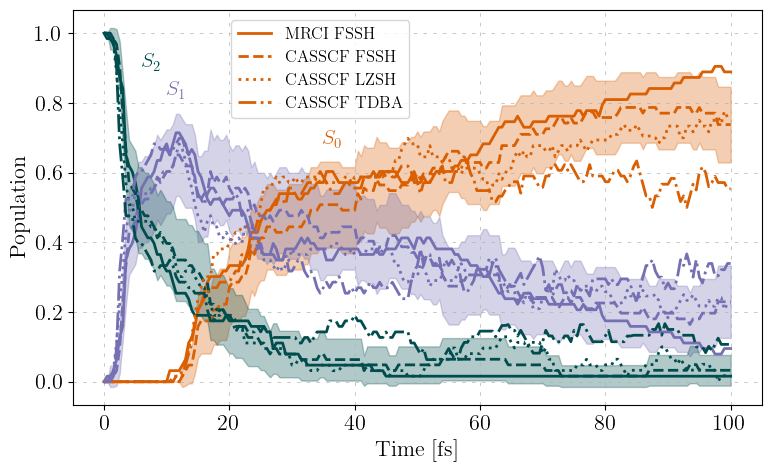

In [10]:
labels = ['MRCI FSSH', 'CASSCF FSSH', 'CASSCF LZSH', 'CASSCF TDBA']
colors = [co1, cp1, cdg1]
lines = ['-', '--', ':', '-.', 'o']

fig, ax = plt.subplots(1, figsize=(8, 5))

ax.text(35, 0.68, '$S_0$', c=co1, fontsize=15)
ax.text(10, 0.82, '$S_1$', c=cp1, fontsize=15)
ax.text(6, 0.9, '$S_2$', c=cdg1, fontsize=15)

for i, name in enumerate(pop_cnh4p.keys()):
    for j in range(nstates):
        if j == 0:
            ax.plot(data_pop_cnh4p[name]['time'], data_pop_cnh4p[name][f'S{j}'], lines[i], c=colors[j], lw=2, label=labels[i])
        else:
            ax.plot(data_pop_cnh4p[name]['time'], data_pop_cnh4p[name][f'S{j}'], lines[i], c=colors[j], lw=2)
        if name == 'CASSCF_FSSH':
            ax.fill_between(data_pop_cnh4p[name]['time'], data_pop_cnh4p[name][f'S{j}pe'], data_pop_cnh4p[name][f'S{j}me'], color=colors[j], alpha=0.3)

ax.set_ylabel('Population')
ax.set_xlabel('Time [fs]')
ax.grid(linestyle = '--', dashes=(5, 9), linewidth = 0.5)

ax.legend(loc="center right", bbox_to_anchor=(0.5,0.85), fontsize=12)

save_fig('populations_cnh4+', tight_layout=True)
plt.tight_layout()
plt.show()


## Discontinuity-induced hops of TDBA trajectory

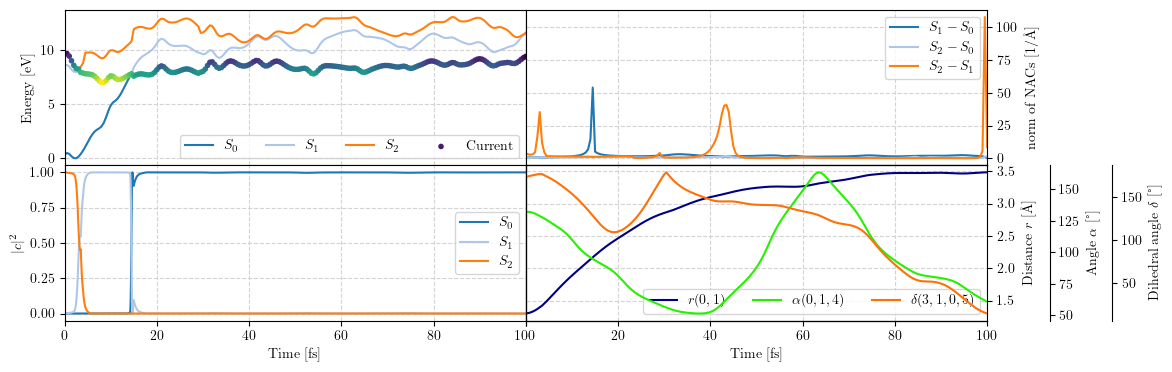

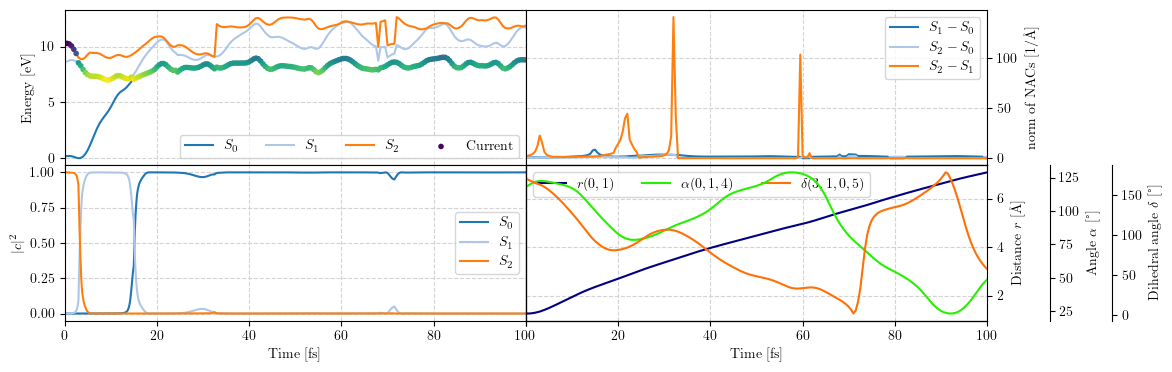

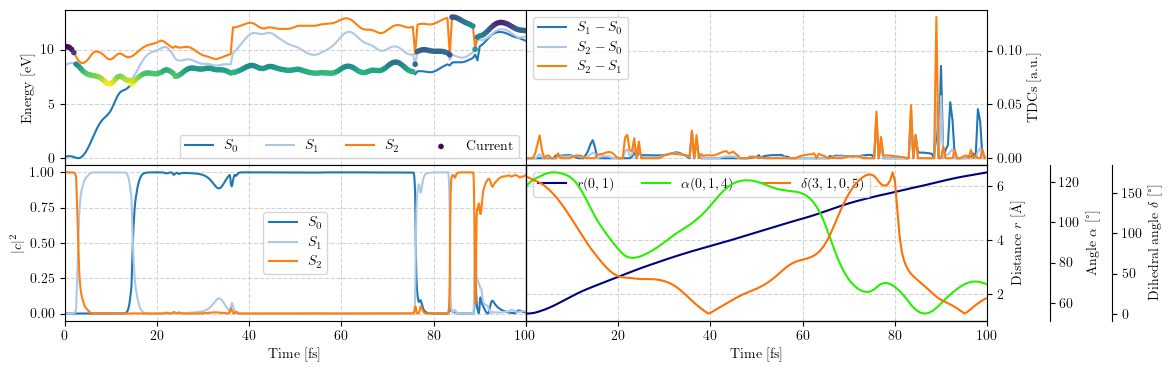

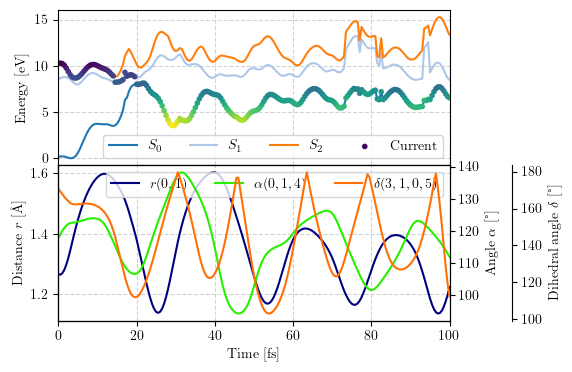

0

In [ ]:
#path = # path to examples/

tr = 40
paths = [
    f'{path}/CNH4p_MRCI_FSSH/TRAJ{tr}/traj_fin.h5',
    f'{path}/CNH4p_CASSCF_FSSH/TRAJ{tr}/traj_fin.h5',
    f'{path}/CNH4p_CASSCF_TDBA/TRAJ{tr}/traj_fin.h5',
    f'{path}/CNH4p_CASSCF_LZSH/TRAJ{tr}/traj_fin.h5'
]

trajs = []
for path in paths:
    traj = ml.data.molecular_trajectory()
    traj.load(path, format='h5md')
    trajs.append(traj)

ml.namd.plot_trajs(trajs, dof=[[0, 1], [0, 1, 4], [3, 1, 0, 5]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=False, save_figure=True)
os.system('mv analysis_nacs_traj_0.png res/')
os.system('rm analysis_*_traj_*.png')

## Single FSSH trajectory with NACs/TDCs or energy-distance only

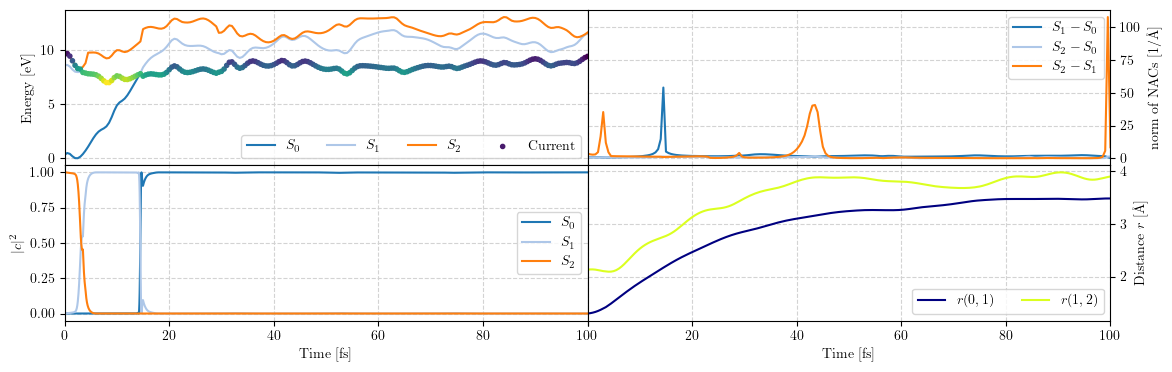

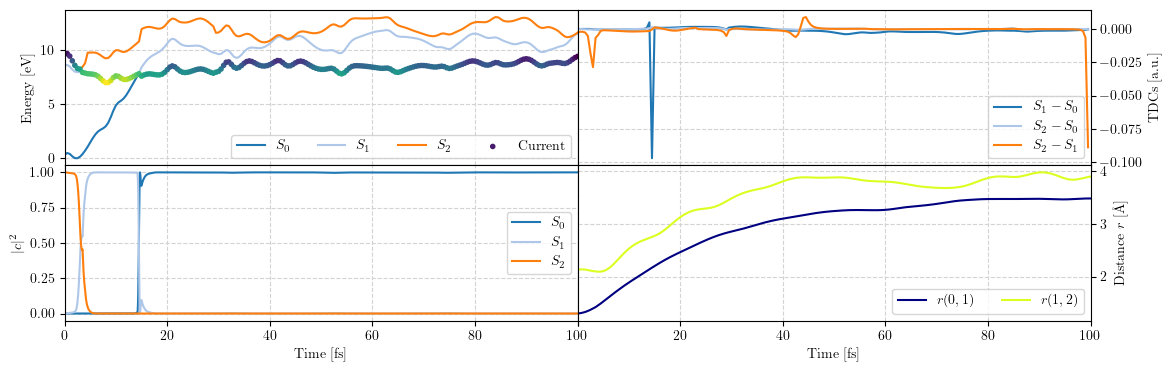

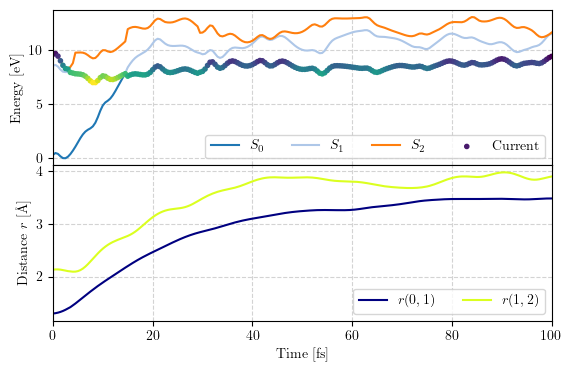

In [ ]:
#path = # path to examples/CNH4p_MRCI_FSSH

traj = ml.data.molecular_trajectory()
traj.load(f'{path}/TRAJ40/traj_fin.h5', format='h5md')

ml.namd.plot_trajs([traj], dof=[[0,1], [1,2]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=False, save_figure=False)
ml.namd.plot_trajs([traj], dof=[[0,1], [1,2]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=True, energy_distance=False, save_figure=False)
ml.namd.plot_trajs([traj], dof=[[0,1], [1,2]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=True, save_figure=False)

## Different types of visualisation of degrees of freedom (dof)
- `dof=[0,1]` means distance between atom0 and atom1
- `dof=[0,1,2]` means angle between atom0, atom1 and atom2
- `dof=[0,1,2,3]` means dihedral angle defined by atom0, atom1, atom2 and atom3

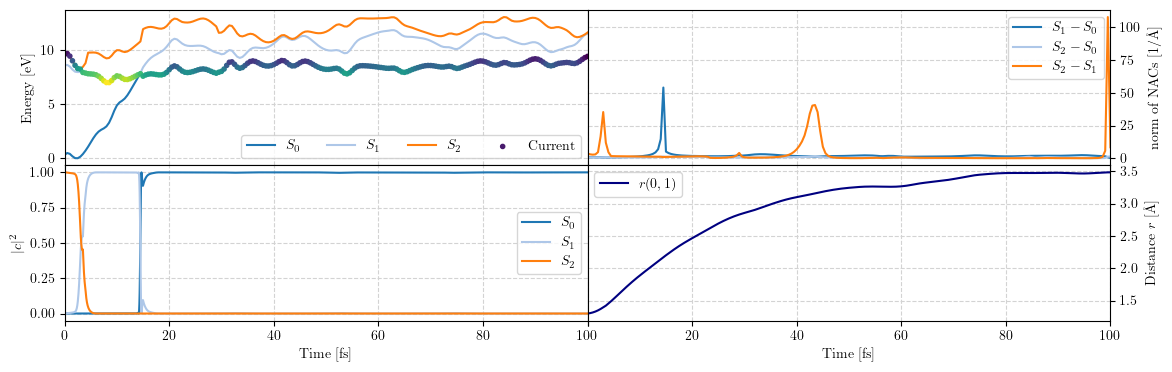

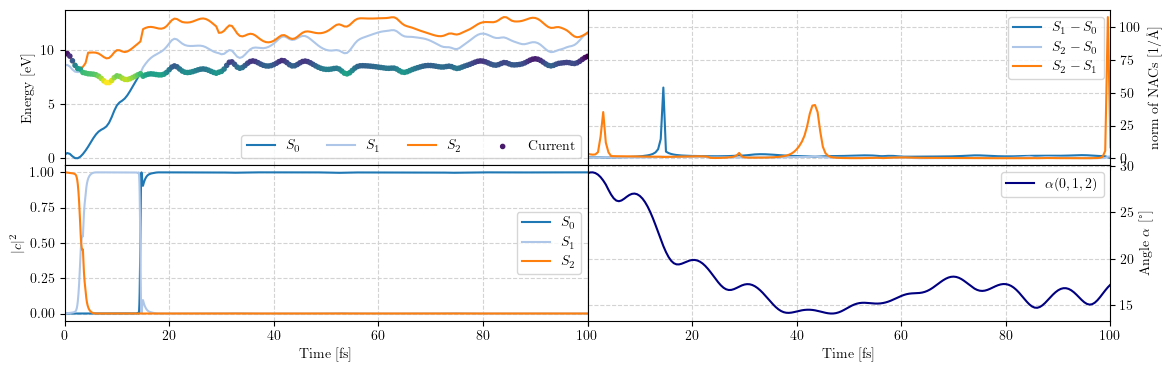

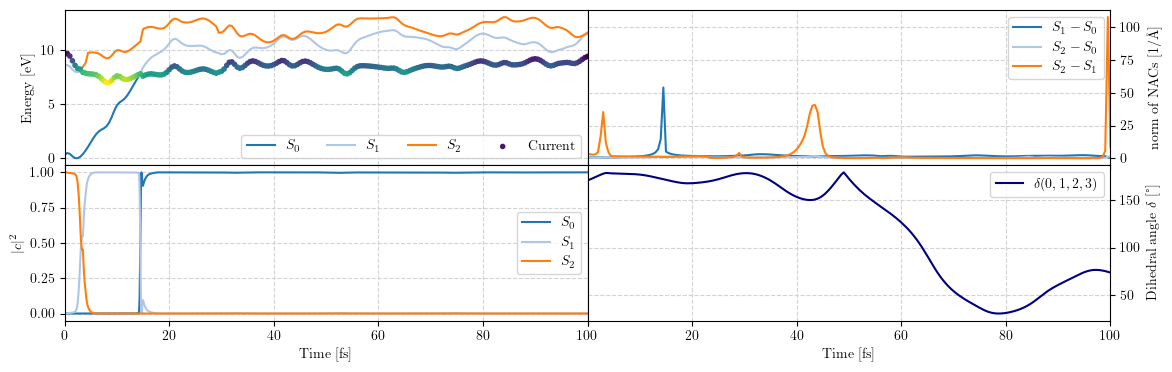

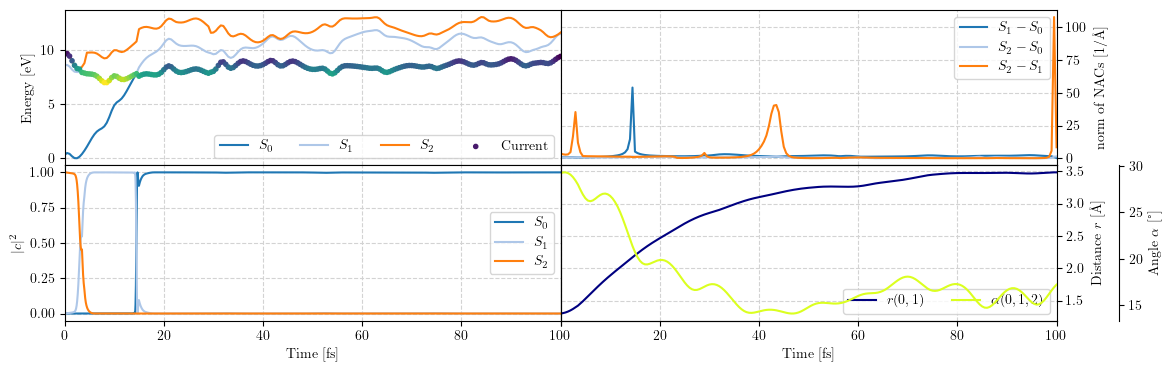

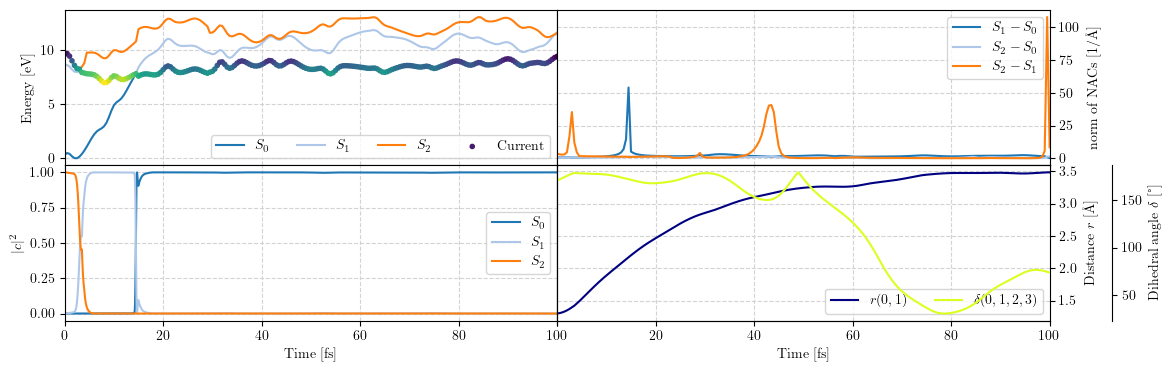

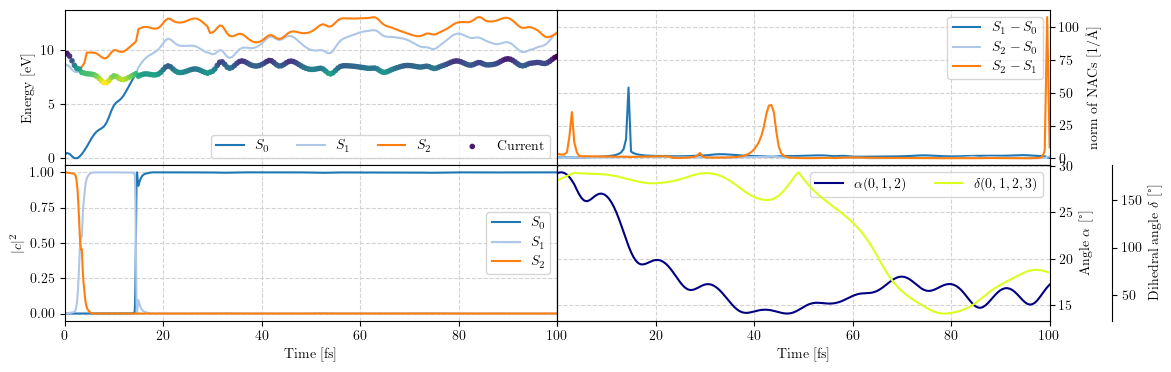

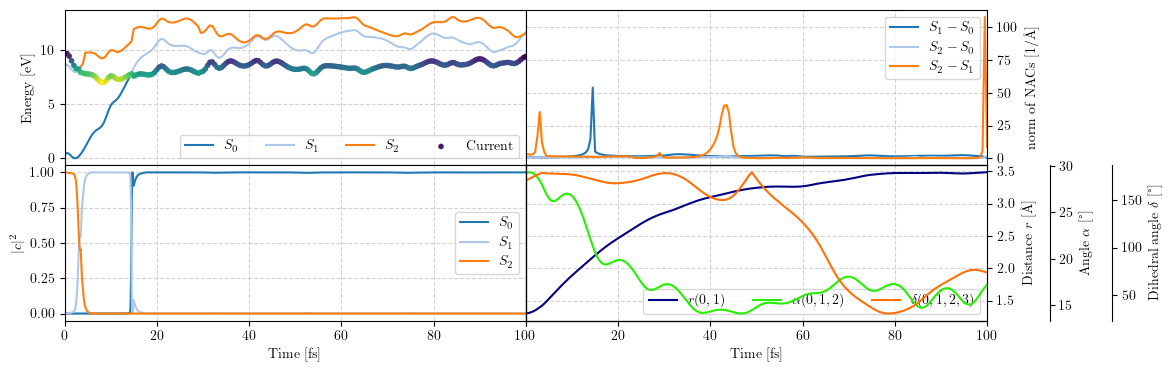

In [ ]:
#path = # path to examples/CNH4p_MRCI_FSSH

traj = ml.data.molecular_trajectory()
traj.load(f'{path}/TRAJ40/traj_fin.h5', format='h5md')

ml.namd.plot_trajs([traj], dof=[[0,1]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=False, save_figure=False)
ml.namd.plot_trajs([traj], dof=[[0,1,2]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=False, save_figure=False)
ml.namd.plot_trajs([traj], dof=[[0,1,2,3]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=False, save_figure=False)
ml.namd.plot_trajs([traj], dof=[[0,1], [0,1,2]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=False, save_figure=False)
ml.namd.plot_trajs([traj], dof=[[0,1], [0,1,2,3]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=False, save_figure=False)
ml.namd.plot_trajs([traj], dof=[[0,1,2], [0,1,2,3]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=False, save_figure=False)
ml.namd.plot_trajs([traj], dof=[[0,1], [0,1,2], [0,1,2,3]], time_step=0.5, time_substep=0.025, max_propagation_time=100, nstates=3, show_tdc=False, energy_distance=False, save_figure=False)

## Extracting hopping geometries

In [ ]:
#path = # path to examples/CNH4p_MRCI_FSSH

db_hop_geoms = ml.data.molecular_database()
for i in range(0, 63):
    traj = ml.data.molecular_trajectory()
    traj.load(f'{path}/TRAJ{i+1}/traj_fin.h5', format='h5md')
    hop_geoms = get_hop_geos(traj)
    for mol in hop_geoms:
        db_hop_geoms.append(mol)

#db_hop_geoms.dump(f"hop_geoms.json", format='json')
#with open('hopping.xyz', 'w') as fw:
#    fw.write(db_hop_geoms.get_xyz_string())

## Internal consistency check

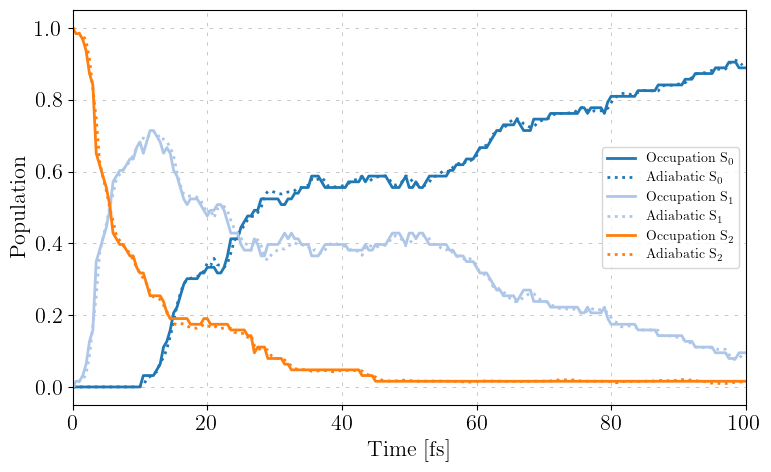

0

In [ ]:
#path = # path to examples/CNH4p_MRCI_FSSH

trajs = []
for i in range(0, 63):
    traj = ml.data.molecular_trajectory()
    traj.load(f'{path}/TRAJ{i+1}/traj_fin.h5', format='h5md')
    trajs.append(traj)

ml.namd.internal_consistency_check(trajectories=trajs, time_step=0.5, max_propagation_time=100.0, nstates=3, save_figure=True)
os.system('mv internal_consistency_check.png res/')